In [20]:
import numpy as np
import pandas as pd
import os
from multiprocessing import Pool
import subprocess
import itertools
import matplotlib.pyplot as plt
import logomaker
import pickle

In [2]:
def motif_to_fasta(bf, kernel, outFasta):
    tmp_df = df[df["kernel"] == kernel].reset_index()
    with open(outFasta, "w") as f:
        for i, row in tmp_df.iterrows():
            chrom, start, end, seq = row.chrom, row.start, row.end, row.seq
            print(">{}:{}-{}".format(chrom, start, end), file=f)
            print(seq, file=f)

def parse_streme_out(streme_out):
    with open(streme_out) as f:
        lines = [line.strip().split() for line in f.readlines()]
    lines = [line for line in lines if len(line) > 0]
    lines = [line for line in lines if line[0].replace(".","").isdigit()]
    ppm = np.array(lines, dtype=float)
    return(ppm)

def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)
    

In [6]:
WIDTHS = [None,8,10,12,14,16,18,24,30]
base_dir = os.getcwd()
data_dir = "../demo/"
prefix = "demo"
motifs_file = data_dir + "motifs.txt.gz"
tmpDir = "/tmp/" + prefix
outPickle = data_dir + ".STREME.pkl"
nCPUs = 4

In [7]:
df = pd.read_csv(motifs_file, 
                 sep="\t", 
                 header=0)

In [8]:
AUCs = dict(zip(df.kernel, df.auc))
motifs_to_refine = [max(AUCs, key=AUCs.get)]

In [9]:
if not os.path.exists(tmpDir):
    os.mkdir(tmpDir)
os.chdir(tmpDir)

In [10]:
for k in motifs_to_refine:
    motif_to_fasta(df, k, "{}.tmp.fa".format(k))

In [11]:
streme_cmds = []
for k in motifs_to_refine:
    for w in WIDTHS:
        if w is None:
            cmd = "streme --nmotifs 1 --order 2 --text -p {0}.tmp.fa > {0}-{1}.streme.out 2> {0}-{1}.streme.err".format(k, "None")
        else:
            cmd = "streme --nmotifs 1 --order 2 --text -w {1} -p {0}.tmp.fa > {0}-{1}.streme.out 2> {0}-{1}.streme.err".format(k, w)
        streme_cmds.append(cmd)

In [12]:
def run(cmd):
    subprocess.run(cmd, shell=True)

In [13]:
with Pool(nCPUs) as p:
    p.map(run, streme_cmds)

In [14]:
PPMs = []
for k, w in itertools.product(motifs_to_refine, WIDTHS):
    streme_out = "{}-{}.streme.out".format(k,w)
    PPMs.append(parse_streme_out(streme_out))

In [15]:
len(PPMs)

9

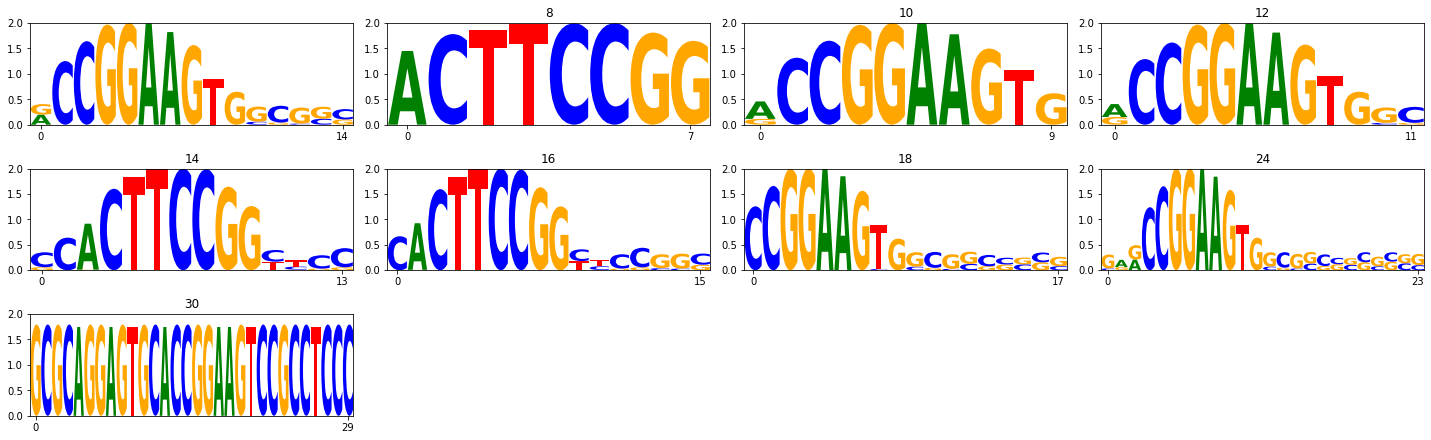

In [16]:
fig, axes = plt.subplots(4,4, figsize=(20,8), tight_layout=True)
for i, (width, ppm) in enumerate(zip(WIDTHS, PPMs)):
    ax = axes.flatten()[i]
    ppm = pd.DataFrame(ppm, columns=["A", "C", "G", "T"])
    w = ppm.shape[0]
    logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
    ax.set_ylim([0,2])
    ax.set_xlim([0-0.5, w-0.5])
    ax.set_xticks([0, w-1])
    ax.set_title(width)
for i in range(len(PPMs), 16):
    fig.delaxes(axes.flatten()[i])

In [18]:
os.chdir(base_dir)
run("rm -r {}".format(tmpDir))

In [21]:
with open(outPickle, "wb") as f:
    pickle.dump(PPMs, f)